In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sensors import *

In [10]:
import pymetis

def metis_speeds(G, ratio):
    '''
        Graph should be undirected.
        Node ids should be integers starting from 0.
    '''
    k = int(ratio * G.number_of_nodes())
    
    nx_adj_list = list(G.adjacency())
    adj_list = []
    
    for i in range(len(nx_adj_list)):
        adj_list.append([])
        for v in nx_adj_list[i][1].keys():
            adj_list[-1].append(v)

    #partitioning the graph using metis
    n_cuts, membership = pymetis.part_graph(k, adjacency=adj_list)
    selected = []
    
    #selecting a random edge 
    for i in range(k):
        part = np.argwhere(np.array(membership) == i).ravel()
        
        if len(part) > 1:
            H = nx.induced_subgraph(G, part)
            selected.append(list(H.edges())[np.random.randint(H.number_of_edges())])
        else:
            #If partition has a single node, picks a random edge adjacent to the node
            selected.append(list(G.edges[part[0]])[0])
        
    return selected

In [64]:
def synthetic_speeds(G):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
    order = np.argsort(eigs[0])
    
    vals = 1e15 * eigs[1][:,-1]
    speeds = {}
    for i, v in enumerate(nx.line_graph(G).nodes()):
        speeds[v] = vals[i]
    return speeds

In [49]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
    speeds = synthetic_speeds(G)
    return G, speeds

In [65]:
G, speeds = read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
speeds

{(1, 117): -0.4036209562625823,
 (117, 116): 1.2853113730284118,
 (116, 115): 0.45545341046112076,
 (116, 294): -2.790917008545515,
 (2, 87): -0.5656503247532967,
 (87, 86): 1.414216106787201,
 (86, 85): -2.594612947576859,
 (86, 189): 0.024396590113633532,
 (3, 74): 1.5603971128809964,
 (74, 73): -3.8463939191086114,
 (73, 72): 4.462459822821545,
 (73, 141): 2.4322146239321096,
 (4, 233): -8.625289094105966,
 (233, 232): 19.78909954238878,
 (232, 58): -15.85157982436632,
 (232, 231): -14.61288598347324,
 (5, 165): 0.5027120947471201,
 (165, 164): -1.5753057615921042,
 (164, 163): 0.5848414289189282,
 (164, 399): 2.228238570741088,
 (6, 213): -0.7029102170014033,
 (213, 212): 1.5630814357712468,
 (212, 211): -1.1703461515587108,
 (212, 408): -1.9137897363542133,
 (7, 253): -1.8567462402508221,
 (253, 252): 4.870704599953607,
 (252, 208): -2.661293449248862,
 (252, 251): -5.24225561929658,
 (8, 411): 0.7096064426432926,
 (411, 8): -0.17653475930389928,
 (411, 410): -1.5960734990368994,


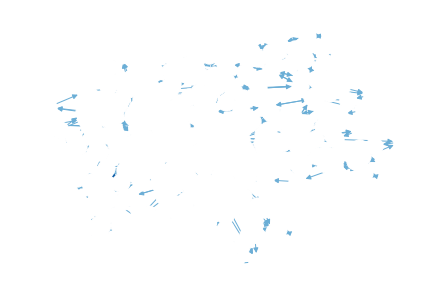

In [67]:
nx.draw(G, edge_color=[speeds[e] for e in G.edges()], node_color="white", edge_cmap=plt.cm.Blues)

In [68]:
def corr(G, sensors, labels, i):
    preds = speed_prediction(G, {s: labels[s] for s in sensors[:i]})
    return np.corrcoef(dict2vect(G, preds), dict2vect(G, labels))[0][1]

In [69]:
def err(G, sensors, labels, i):
    preds = flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]})
    return mse(preds, labels)

In [70]:
k = int(G.number_of_edges())

random_sensors = choose_sensors_random(G, k=k)
greedy_sensors = choose_sensors(G, speeds, speed_prediction, mse, k=k)

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge


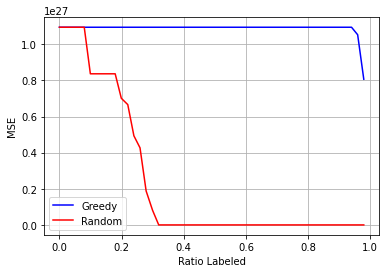

In [71]:
samples = 50
greedy, rand = {}, {}

for j in tqdm(range(samples)):
    i = int(k * j / samples)
        
    greedy[i] = err(G, greedy_sensors, speeds, i)
    rand[i] = err(G, random_sensors, speeds, i)
        
fig, ax = plt.subplots()
    
ax.plot([k / G.number_of_edges() for k in greedy.keys()], greedy.values(), "b", label="Greedy")
ax.plot([k / G.number_of_edges() for k in rand.keys()], rand.values(), "r", label="Random")
    
ax.legend()
plt.xlabel("Ratio Labeled")
plt.ylabel("MSE")
plt.grid("on")